<a href="https://colab.research.google.com/github/billycemerson/quantitative-finance-project/blob/main/01_foundations/volatility_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import math

#### Get Data

In [ ]:
data = yf.download("BBCA.JK", start="2021-01-01", end="2024-12-31", interval="1d",
                   progress=False, auto_adjust=False)
data.head()

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,BBCA.JK,BBCA.JK,BBCA.JK,BBCA.JK,BBCA.JK,BBCA.JK
Date,,,,,,
2021-01-04,6028.375000,6835.0,6855.0,6720.0,6800.0,47937000
2021-01-05,6253.281250,7090.0,7090.0,6850.0,6860.0,104831000
2021-01-06,6125.392578,6945.0,7075.0,6880.0,7050.0,89753500
2021-01-07,6143.033203,6965.0,7050.0,6910.0,7000.0,71360000
2021-01-08,6218.001465,7050.0,7080.0,6975.0,7035.0,75033500


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 969 entries, 2021-01-04 to 2024-12-30
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   (Adj Close, BBCA.JK)  969 non-null    float64
 1   (Close, BBCA.JK)      969 non-null    float64
 2   (High, BBCA.JK)       969 non-null    float64
 3   (Low, BBCA.JK)        969 non-null    float64
 4   (Open, BBCA.JK)       969 non-null    float64
 5   (Volume, BBCA.JK)     969 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 53.0 KB


#### Historical Volatility

In [ ]:
# Calculate historical volatility (rolling std)
data['hist_vol'] = data['Close'].pct_change().rolling(window=252).std()
data.head()

Price,Adj Close,Close,High,Low,Open,Volume,hist_vol
Ticker,BBCA.JK,BBCA.JK,BBCA.JK,BBCA.JK,BBCA.JK,BBCA.JK,
Date,,,,,,,
2021-01-04,6028.375000,6835.0,6855.0,6720.0,6800.0,47937000,NaN
2021-01-05,6253.281250,7090.0,7090.0,6850.0,6860.0,104831000,NaN
2021-01-06,6125.392578,6945.0,7075.0,6880.0,7050.0,89753500,NaN
2021-01-07,6143.033203,6965.0,7050.0,6910.0,7000.0,71360000,NaN
2021-01-08,6218.001465,7050.0,7080.0,6975.0,7035.0,75033500,NaN


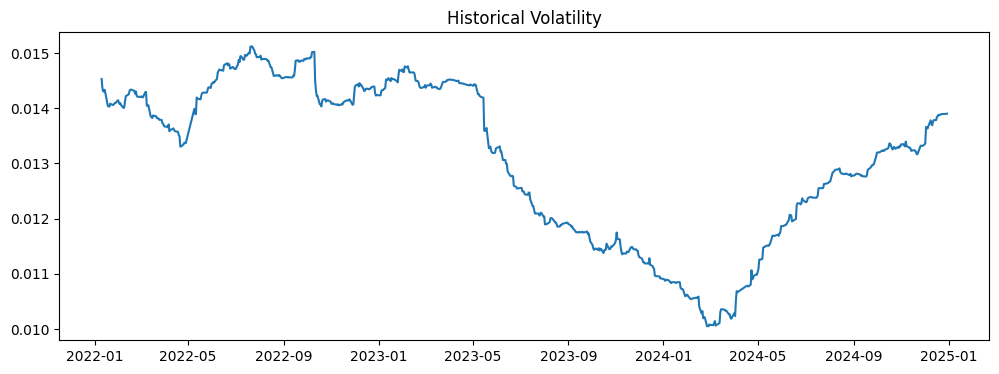

In [ ]:
# Plot history volatility
plt.figure(figsize=(12, 4))
plt.plot(data['hist_vol'])
plt.title('Historical Volatility')
plt.show()

#### Parkinson

Parkinson's volatility uses the stock’s high and low price of the day rather than just close to close prices. It’s useful to capture large price movements during the day.

In [ ]:
def parkinson(price_data, window=30, trading_periods=252, clean=True):

    rs = (1.0 / (4.0 * math.log(2.0))) * (
        (price_data["High"] / price_data["Low"]).apply(np.log)
    ) ** 2.0

    def f(v):
        return (trading_periods * v.mean()) ** 0.5

    result = rs.rolling(window=window, center=False).apply(func=f)

    if clean:
        return result.dropna()
    else:
        return result

In [ ]:
parkinson = parkinson(data)
parkinson.head()

Ticker,BBCA.JK
Date,
2021-02-15,0.258892
2021-02-16,0.258207
2021-02-17,0.252680
2021-02-18,0.251506
2021-02-19,0.250133


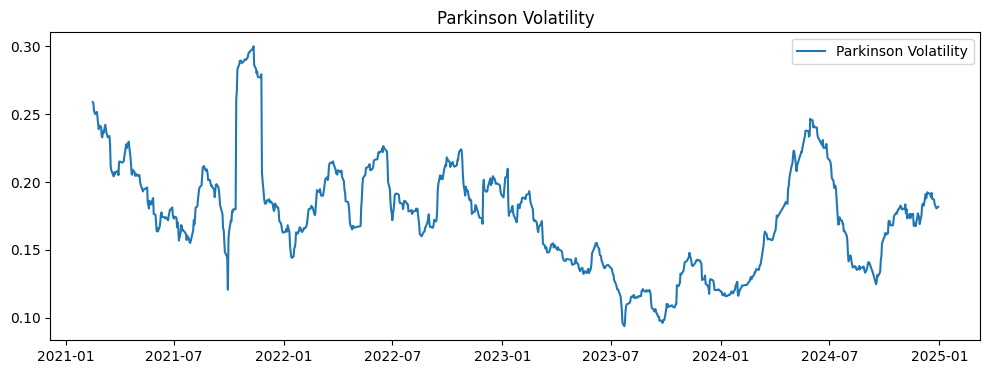

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(parkinson['BBCA.JK'])
plt.title('Parkinson Volatility')
plt.legend(['Parkinson Volatility'])
plt.show()

#### Garman-Klass

Garman-Klass volatility extends Parkinson's volatility by taking into account the opening and closing price. As markets are most active during the opening and closing of a trading session, it makes volatility estimation more accurate.

In [ ]:
def garman_klass(price_data, window=30, trading_periods=252, clean=True):

    log_hl = (price_data["High"] / price_data["Low"]).apply(np.log)
    log_co = (price_data["Close"] / price_data["Open"]).apply(np.log)

    rs = 0.5 * log_hl ** 2 - (2 * math.log(2) - 1) * log_co ** 2

    def f(v):
        return (trading_periods * v.mean()) ** 0.5

    result = rs.rolling(window=window, center=False).apply(func=f)

    if clean:
        return result.dropna()
    else:
        return result

In [ ]:
garman_klass = garman_klass(data)
garman_klass.head()

Ticker,BBCA.JK
Date,
2021-02-15,0.252853
2021-02-16,0.251565
2021-02-17,0.250783
2021-02-18,0.248742
2021-02-19,0.246692


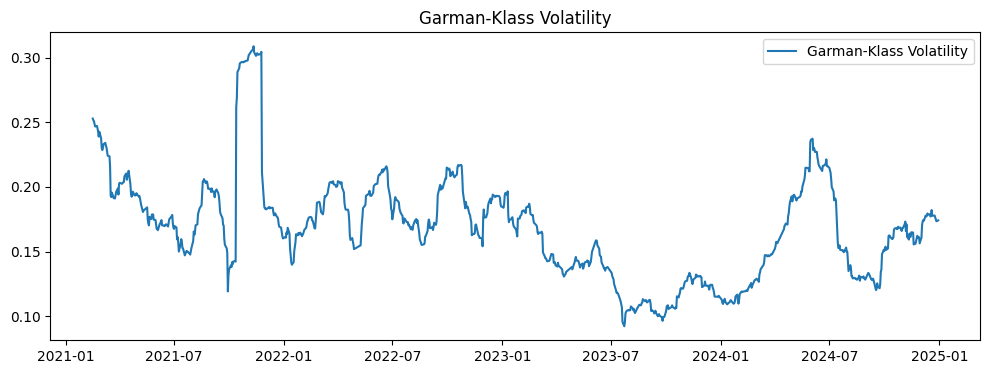

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(garman_klass['BBCA.JK'])
plt.title('Garman-Klass Volatility')
plt.legend(['Garman-Klass Volatility'])
plt.show()

#### Hodges-Tompkins

Hodges-Tompkins volatility is a bias correction for estimation using an overlapping data sample that produces unbiased estimates and a substantial gain in efficiency.

In [ ]:
def hodges_tompkins(price_data, window=30, trading_periods=252, clean=True):

    log_return = (price_data["Close"] / price_data["Close"].shift(1)).apply(np.log)

    vol = log_return.rolling(window=window, center=False).std() * math.sqrt(
        trading_periods
    )

    h = window
    n = (log_return.count() - h) + 1

    adj_factor = 1.0 / (1.0 - (h / n) + ((h ** 2 - 1) / (3 * n ** 2)))

    result = vol * adj_factor

    if clean:
        return result.dropna()
    else:
        return

In [ ]:
hodges_tompkins = hodges_tompkins(data)
hodges_tompkins

Ticker,BBCA.JK
Date,
2021-02-16,0.268300
2021-02-17,0.244349
2021-02-18,0.247214
2021-02-19,0.250669
2021-02-22,0.247806
...,...
2024-12-20,0.269715
2024-12-23,0.271959
2024-12-24,0.271963


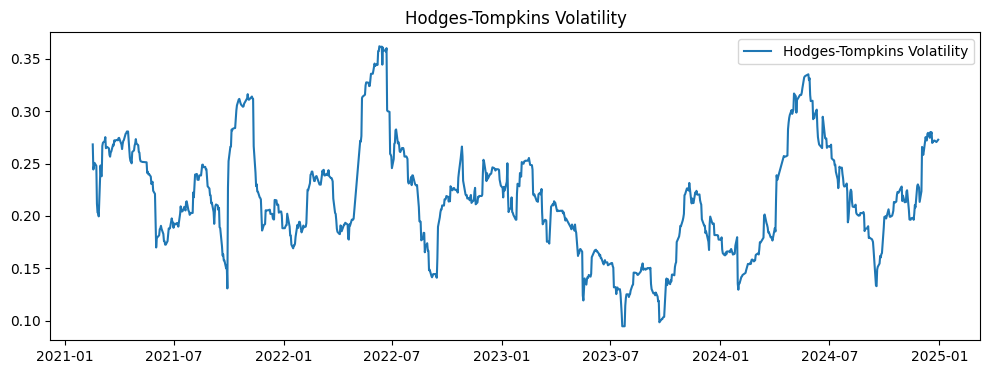

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(hodges_tompkins['BBCA.JK'])
plt.title('Hodges-Tompkins Volatility')
plt.legend(['Hodges-Tompkins Volatility'])
plt.show()

#### Rogers-Satchell

Rogers-Satchell is an estimator for measuring the volatility of securities with an average return not equal to zero. Unlike Parkinson and Garman-Klass estimators, Rogers-Satchell incorporates a drift term (mean return not equal to zero).

In [ ]:
def rogers_satchell(price_data, window=30, trading_periods=252, clean=True):

    log_ho = (price_data["High"] / price_data["Open"]).apply(np.log)
    log_lo = (price_data["Low"] / price_data["Open"]).apply(np.log)
    log_co = (price_data["Close"] / price_data["Open"]).apply(np.log)

    rs = log_ho * (log_ho - log_co) + log_lo * (log_lo - log_co)

    def f(v):
        return (trading_periods * v.mean()) ** 0.5

    result = rs.rolling(window=window, center=False).apply(func=f)

    if clean:
        return result.dropna()
    else:
        return result

In [ ]:
rogers_satchell = rogers_satchell(data)
rogers_satchell

Ticker,BBCA.JK
Date,
2021-02-15,0.250290
2021-02-16,0.248589
2021-02-17,0.249931
2021-02-18,0.247920
2021-02-19,0.245826
...,...
2024-12-20,0.175831
2024-12-23,0.176886
2024-12-24,0.178712


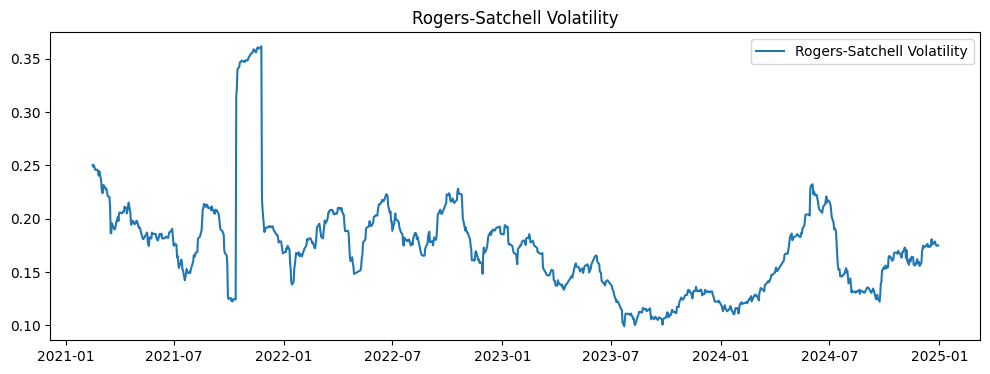

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(rogers_satchell['BBCA.JK'])
plt.title('Rogers-Satchell Volatility')
plt.legend(['Rogers-Satchell Volatility'])
plt.show()

#### Yang-Zhang

Yang-Zhang volatility is the combination of the overnight (close-to-open volatility), a weighted average of the Rogers-Satchell volatility and the day's open-to-close volatility.

In [ ]:
def yang_zhang(price_data, window=30, trading_periods=252, clean=True):

    log_ho = (price_data["High"] / price_data["Open"]).apply(np.log)
    log_lo = (price_data["Low"] / price_data["Open"]).apply(np.log)
    log_co = (price_data["Close"] / price_data["Open"]).apply(np.log)

    log_oc = (price_data["Open"] / price_data["Close"].shift(1)).apply(np.log)
    log_oc_sq = log_oc ** 2

    log_cc = (price_data["Close"] / price_data["Close"].shift(1)).apply(np.log)
    log_cc_sq = log_cc ** 2

    rs = log_ho * (log_ho - log_co) + log_lo * (log_lo - log_co)

    close_vol = log_cc_sq.rolling(window=window, center=False).sum() * (
        1.0 / (window - 1.0)
    )
    open_vol = log_oc_sq.rolling(window=window, center=False).sum() * (
        1.0 / (window - 1.0)
    )
    window_rs = rs.rolling(window=window, center=False).sum() * (1.0 / (window - 1.0))

    k = 0.34 / (1.34 + (window + 1) / (window - 1))
    result = (open_vol + k * close_vol + (1 - k) * window_rs).apply(
        np.sqrt
    ) * math.sqrt(trading_periods)

    if clean:
        return result.dropna()
    else:
        return result

In [ ]:
yang_zhang = yang_zhang(data)
yang_zhang

Ticker,BBCA.JK
Date,
2021-02-16,0.318932
2021-02-17,0.317878
2021-02-18,0.317070
2021-02-19,0.315698
2021-02-22,0.315821
...,...
2024-12-20,0.254744
2024-12-23,0.255907
2024-12-24,0.244782


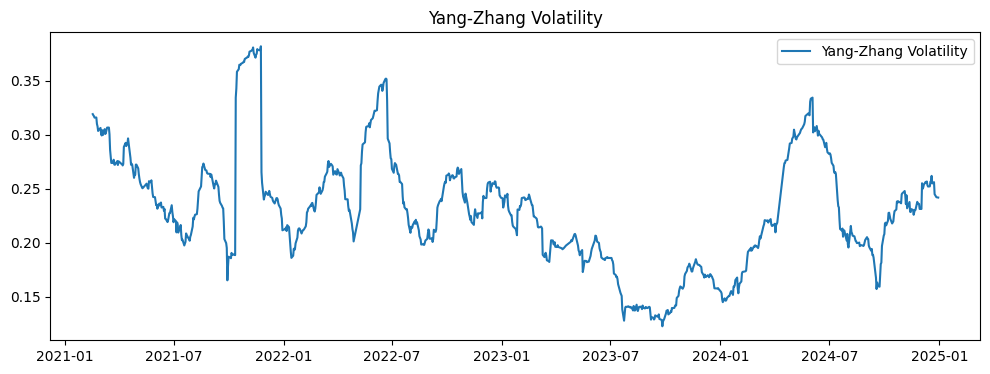

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(yang_zhang['BBCA.JK'])
plt.title('Yang-Zhang Volatility')
plt.legend(['Yang-Zhang Volatility'])
plt.show()